In [1]:
from trainer import Trainer
from model.base_model_fine_tune import BaseNetTuned
import pathlib
import utils
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub

%matplotlib inline
%load_ext autoreload
%autoreload 2

## fine model

In [2]:
params = utils.Params(pathlib.Path('experiments/small_model_fine/params.json'))

In [3]:
net = BaseNetTuned(params=params)

In [4]:
model = net.get_model()

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
model.layers

In [7]:
len(model.layers[0].layers)

175

In [8]:
len(model.layers[0].trainable_variables)

0

In [57]:
len(model.layers[1].trainable_variables)

2

In [9]:
net.unfreeze()

In [10]:
model = net.get_model()

In [11]:
len(model.layers[0].trainable_variables)

90

In [12]:
len(model.layers[1].trainable_variables)

0

In [13]:
len(model.trainable_variables)

92

## fine trainer

In [29]:
trainer = Trainer(experiment_dir=pathlib.Path('experiments/small_model_fine'))

start loading datasets ...
done loading datasets


In [30]:
trainer.train()

Train for 16 steps, validate for 2 steps
Epoch 1/2
15/16 [===========================>..] - ETA: 2s - loss: 0.4130 - categorical_accuracy: 0.8000
Epoch 00001: val_loss improved from inf to 0.89959, saving model to experiments/small_model_fine/weights_val_loss
16/16 [==============================] - 38s 2s/step - loss: 0.4165 - categorical_accuracy: 0.7969 - val_loss: 0.8996 - val_categorical_accuracy: 0.5000
Epoch 2/2
15/16 [===========================>..] - ETA: 1s - loss: 0.2876 - categorical_accuracy: 0.8750
Epoch 00002: val_loss did not improve from 0.89959
16/16 [==============================] - 26s 2s/step - loss: 0.2737 - categorical_accuracy: 0.8828 - val_loss: 1.2393 - val_categorical_accuracy: 0.4375


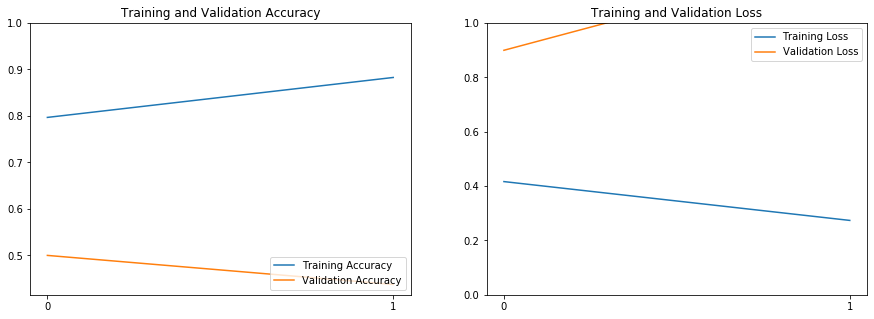

In [31]:
trainer.plot_history()

In [32]:
trainer.unfreeze()

In [33]:
trainer.train_fine()

Train for 16 steps, validate for 2 steps
Epoch 3/3
15/16 [===========================>..] - ETA: 3s - loss: 0.2479 - categorical_accuracy: 0.9250
Epoch 00003: val_loss did not improve from 0.89959
16/16 [==============================] - 53s 3s/step - loss: 0.2494 - categorical_accuracy: 0.9219 - val_loss: 0.9316 - val_categorical_accuracy: 0.5000


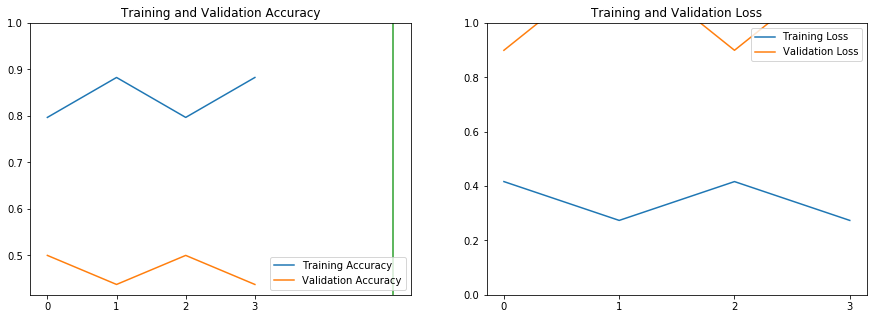

In [34]:
trainer.plot_history(fine=True)